In [59]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [60]:
def visualize(arr: np.array):
    img = np.copy(arr)
    img = img - img.min()
    img = img / img.max()
    plt.imshow(img)


def magnitude2(arrX: np.array, arrY: np.array):
    return np.sqrt(arrX**2 + arrY**2)


def interp2(u, v, x, y):
    X = np.floor(x).astype(int)
    Y = np.floor(y).astype(int)
    fracX = x - X
    fracY = y - Y

    A = np.array([u[X + 0, Y + 0], v[X + 0, Y + 0]])
    B = np.array([u[X + 1, Y + 0], v[X + 1, Y + 0]])
    C = np.array([u[X + 0, Y + 1], v[X + 0, Y + 1]])
    D = np.array([u[X + 1, Y + 1], v[X + 1, Y + 1]])
    U1 = (1.0 - fracX) * A + fracX * B
    U2 = (1.0 - fracX) * C + fracX * D
    U = (1.0 - fracY) * U1 + fracY * U2
    return U

def interp1(a, x, y):
    X = np.floor(x).astype(int)
    Y = np.floor(y).astype(int)
    fracX = x - X
    fracY = y - Y

    U1 = (1.0 - fracX) * a[X + 0, Y + 0] + fracX * a[X + 1, Y + 0]
    U2 = (1.0 - fracX) * a[X + 0, Y + 1] + fracX * a[X + 1, Y + 1]
    U = (1.0 - fracY) * U1 + fracY * U2
    return U

In [61]:
d1 = h5py.File('../metsim1_2d.h5', 'r')
u = np.array(d1["Velocity"]["X-comp"]).T
v = np.array(d1["Velocity"]["Y-comp"]).T
img = np.array([u, v, np.zeros_like(u)]).T
img.shape

(127, 127, 3)

In [62]:
trajectories = []
num_seeds = 150
mesh_size = u.shape[0]

# generate seeds
particles_per_dim = np.ceil(np.sqrt(num_seeds)).astype(int)
print(particles_per_dim)
meshgrid = np.meshgrid(np.linspace(0, mesh_size, particles_per_dim), np.linspace(0, mesh_size, particles_per_dim))
seeds_x = meshgrid[0].flatten()
seeds_y = meshgrid[1].flatten()

for i in range(num_seeds):
    pos_x = seeds_x[i]
    pos_y = seeds_y[i]
    trajectory_x = [pos_x]
    trajectory_y = [pos_y]
    T = 50
    dt = 1.0
    steps = int(T / dt)

    for j in range(steps):
        if pos_x < 0 or pos_y < 0:
            break
        elif pos_x >= u.shape[0]-2 or pos_y > u.shape[0]-2:
            break
        
        k1x = interp1(u, pos_x, pos_y)
        k1y = interp1(v, pos_x, pos_y)
        
        k2x = interp1(u, pos_x + 0.5 * dt * k1x, pos_y + 0.5 * dt * k1y)
        k2y = interp1(v, pos_x + 0.5 * dt * k1x, pos_y + 0.5 * dt * k1y)
        
        k3x = interp1(u, pos_x + 0.5 * dt * k2x, pos_y + 0.5 * dt * k2y)
        k3y = interp1(v, pos_x + 0.5 * dt * k2x, pos_y + 0.5 * dt * k2y)
        
        k4x = interp1(u, pos_x + dt * k3x, pos_y + dt * k3y)
        k4y = interp1(v, pos_x + dt * k3x, pos_y + dt * k3y)
        
        pos_x += (dt / 6) * (k1x + 2 * k2x + 2 * k3x + k4x)
        pos_y += (dt / 6) * (k1y + 2 * k2y + 2 * k3y + k4y)
        
        trajectory_x.append(pos_x)
        trajectory_y.append(pos_y)
    
    trajectories.append([trajectory_x, trajectory_y])


13


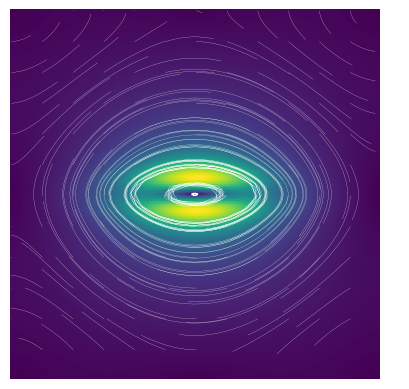

In [63]:
plt.axis('off')
visualize(magnitude2(u.T, v.T))
for traj in trajectories:
    plt.plot(traj[0], traj[1], 'w', linewidth=0.15)
plt.savefig("metsim_uniform_rk4.eps", bbox_inches='tight', pad_inches=0)

In [64]:
#euler 

trajectories = []
num_seeds = 150
mesh_size = u.shape[0]

# generate seeds
particles_per_dim = np.ceil(np.sqrt(num_seeds)).astype(int)
print(particles_per_dim)
meshgrid = np.meshgrid(np.linspace(0, mesh_size, particles_per_dim), np.linspace(0, mesh_size, particles_per_dim))
seeds_x = meshgrid[0].flatten()
seeds_y = meshgrid[1].flatten()

for i in range(num_seeds):
    pos_x = seeds_x[i]
    pos_y = seeds_y[i]
    trajectory_x = [pos_x]
    trajectory_y = [pos_y]
    T = 50
    dt = 1.0
    steps = int(T / dt)

    for j in range(steps):
        if pos_x < 0 or pos_y < 0:
            break
        elif pos_x >= u.shape[0]-2 or pos_y > u.shape[0]-2:
            break

        pos_x += interp1(u, pos_x, pos_y) * dt
        pos_y += interp1(v, pos_x, pos_y) * dt
        trajectory_x.append(pos_x)
        trajectory_y.append(pos_y)
    trajectories.append([trajectory_x, trajectory_y])

13


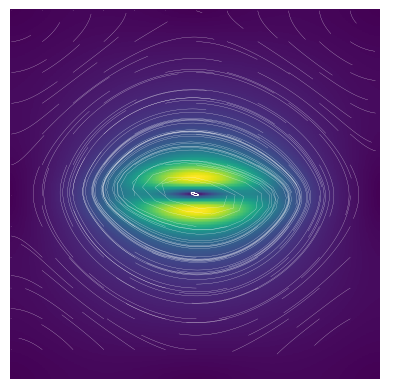

In [65]:
plt.axis('off')
visualize(magnitude2(u.T, v.T))
for traj in trajectories:
    plt.plot(traj[0], traj[1], 'w', linewidth=0.15)
plt.savefig("metsim_uniform_euler.eps", bbox_inches='tight', pad_inches=0)